<a href="https://colab.research.google.com/github/znah/notebooks/blob/master/mini_sinkhorn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sinkhorn iteration for optimal transport with Tensorflow

In [14]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import cv2

def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [10]:
def gen_points(s, font_size=42):
  font = PIL.ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', font_size)
  w, h = font.getsize(s)
  im = PIL.Image.new('L', (w, h))
  draw  = PIL.ImageDraw.Draw(im)
  draw.text((0, 0), s, fill=255, font=font)
  im = np.uint8(im)
  y, x = np.float32(im.nonzero())
  pos = np.column_stack([x, y])
  if len(pos) > 0:
    pos -= (w/2, h/2)
    pos /= font_size
  return pos


In [11]:
# along the lines of
# https://nbviewer.jupyter.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_6_entropic_adv.ipynb

@tf.function
def pdist(x, y):
  dx = x[:, None, :] - y[None, :, :]
  return tf.reduce_sum(tf.square(dx), -1)

@tf.function
def Sinkhorn_step(C, f):
  g = tf.reduce_logsumexp(-f-tf.transpose(C), -1)
  f = tf.reduce_logsumexp(-g-C, -1)
  return f, g

def Sinkhorn(C, f=None, niter=1000):
  n = tf.shape(C)[0]
  if f is None:
    f = tf.zeros(n, np.float32)
  for i in range(niter):
    f, g = Sinkhorn_step(C, f)
  P = tf.exp(-f[:,None]-g[None,:]-C)/tf.cast(n, tf.float32)
  return P, f, g

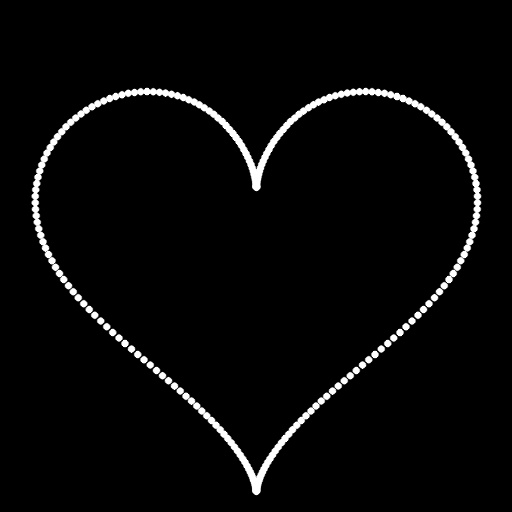

In [15]:
VIDEO_SIZE = 512

def draw_points(p):
  w = VIDEO_SIZE
  img = np.zeros((w, w, 3), np.uint8)
  #img[:] = 255
  p = np.int32((w/2+p*w*0.9)*4)
  for x, y in p:
    cv2.circle(img, (x, y), 12, (255, 255, 255), -1, cv2.CV_AA, shift=2)
  return img

t = np.linspace(0, 2*np.pi, 256)
x = 16*np.sin(t)**3
y = 13*np.cos(t)-5*np.cos(2*t)-2*np.cos(3*t)-np.cos(4*t)
pos0 = np.float32(np.column_stack([x*0.03, -y*0.03]))

imshow(draw_points(pos0)/255.0)


In [29]:
pos = pos0.copy()
vel = np.zeros_like(pos)

with VideoWriter('out.mp4', 60.0) as video:
  video.add(draw_points(pos))
  f = None
  for s in 'ILOVEU ':
    target = gen_points(s) if s != ' ' else pos0
    for i in range(100):
      C = pdist(pos, target)/(0.01)**2
      P, f, g = Sinkhorn(C, f=f, niter=20)
      P = P.numpy()
      g = P.dot(target)*len(pos)-pos
      vel = vel*0.8 + 0.2*g
      pos += 0.1*vel
      frame = draw_points(pos)
      video.add(frame)
    print(s, end='', flush=True)

video.show(loop=True)  

ILOVEU 